# Exercise 1

Design a machine for protons at a total energy of 20 GeV with the following basic parameters: 

- circumference = 1000 m,
- quadrupole length $L_{q}$ = 3.0 m,
- 8 FODO cells,
- dipole length is 5 m, maximum field is 3 T.

Apply the knowledge from previous lectures at this school and define a lattice cell according to the boundary conditions (position of dipole magnets and quadrupoles) and find the optics (strength of dipoles and quadrupoles) so that $\beta_{max}=\hat{\beta}$ is around 300 m. Implement 
it in MAD-X format using thin lenses for all elements and verify the calculations.


In [1]:
!pwd
from cpymad.madx import Madx
madx = Madx()
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

/Users/sterbini/CERNbox/2022/CAS/Sevrier2022/exercises/solutions/Exercise1

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.08 16:57:19      +
  ++++++++++++++++++++++++++++++++++++++++++++


/var/folders/vg/x_r9qxhj4y55x8swvp3pw60w0000gn/T/ipykernel_70035/1525001913.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


In [13]:
import numpy as np
L = 125
def fun(f):
    return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)-300

import scipy

f=scipy.optimize.root(fun, 100)['x']
k1= 1/f/3
k1

array([0.00295278])

In [2]:
madx.input('''
TITLE, ’CAS2019 First Exercise’; 

circum=1000.0;
ncell = 8; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

/***element definitions***/

!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole, knl={2.0*pi/(4*ncell)};

!define quadrupoles as multipoles 
qf: multipole,knl={0,0.295278e-2*lq}; 
qd: multipole,knl={0,-0.295278e-2*lq};

!sequence declaration;
cas1: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf, at=(n-1)*lcell;
    mb: mb, at=(n-1)*lcell+0.15*lcell;
    mb: mb, at=(n-1)*lcell+0.35*lcell;
    qd: qd, at=(n-1)*lcell+0.50*lcell;
    mb: mb, at=(n-1)*lcell+0.65*lcell;
    mb: mb, at=(n-1)*lcell+0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties

beam, particle = proton, sequence=cas1, energy = 20.0;

!define the desired output

use, sequence=cas1;
select,flag=twiss,column=name,s,x,y,mux,betx,alfx,muy,bety,alfy,dx,dy;

!execute the TWISS command 
twiss;
!twiss,save,centre,file=twiss.out;
!plot, haxis=s, vaxis=betx, bety, dx, colour=100;
survey;
!survey, file=survey.out;
''');

++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0        1.989271492       0.7090109959 

                q1                dq1            betxmax              dxmax 
      0.7142528897      -0.7344010504        299.9996549        365.0168477 

             dxrms             xcomax             xcorms                 q2 
       321.4860068                  

### The machine SURVEY

In [6]:
mySurvey=madx.table.survey.dframe()

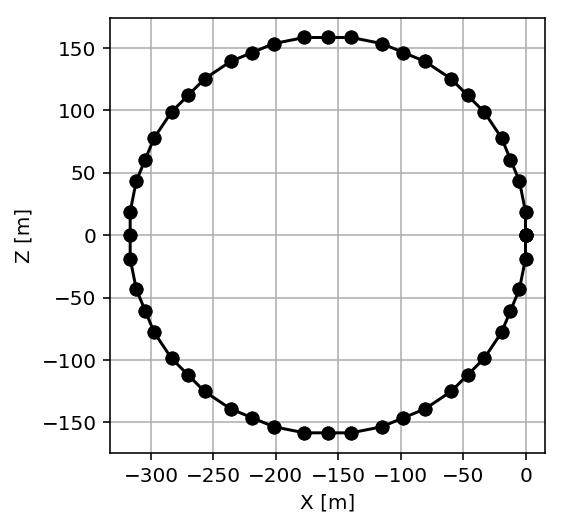

In [7]:
plt.plot(mySurvey.x,mySurvey.z,'o-k')
plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

In [8]:
# Check the closure of the machine by comparting the coordinates of the machine's start and end.
display(mySurvey.head(1))
mySurvey.tail(1)

,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,slot_id,assembly_id,mech_sep,v_pos,comments
#s,cas1$start:1,marker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,slot_id,assembly_id,mech_sep,v_pos,comments
#e,cas1$end:1,marker,1000.0,0.0,0.0,-3.388886e-13,0.0,-8.171241e-14,-6.283185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


### The machine TWISS

In [9]:
myTwiss=madx.table.twiss.dframe()

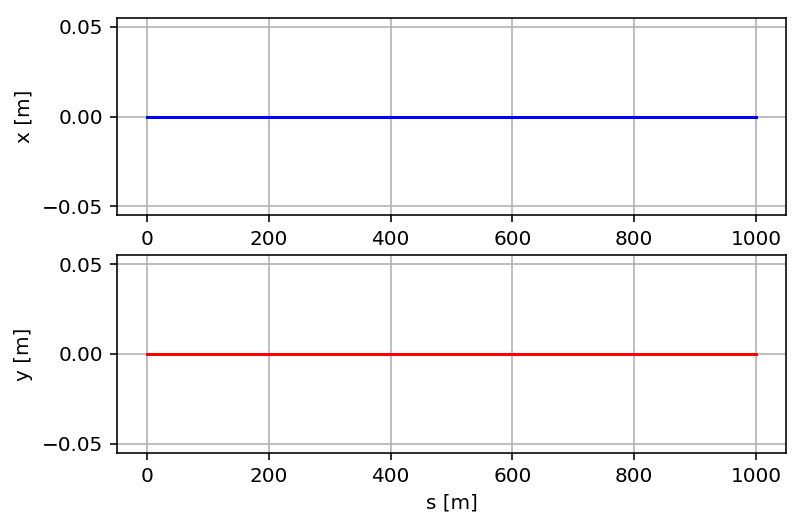

In [10]:
# The Closed orbit corresponds to the reference orbit
plt.subplot(211)
plt.plot(myTwiss.s,myTwiss.x,'b')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwiss.s,myTwiss.y,'r')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()

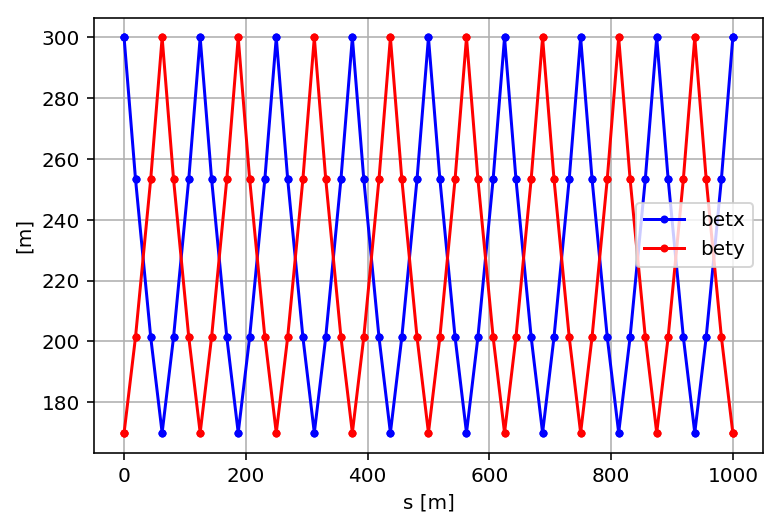

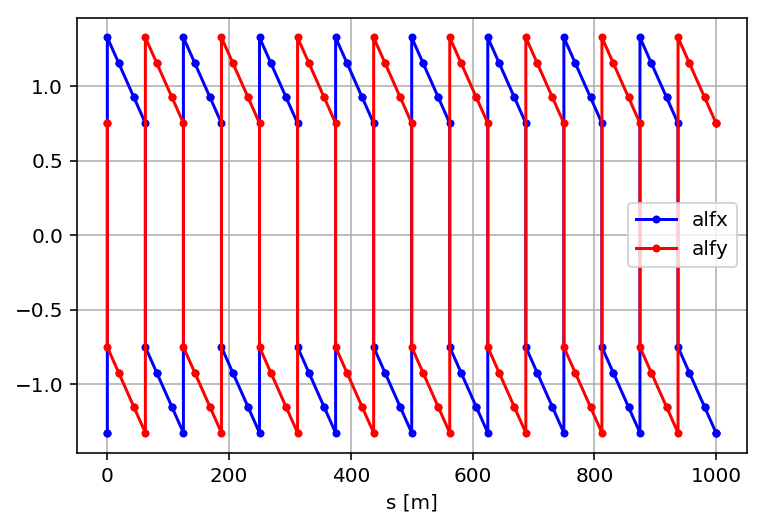

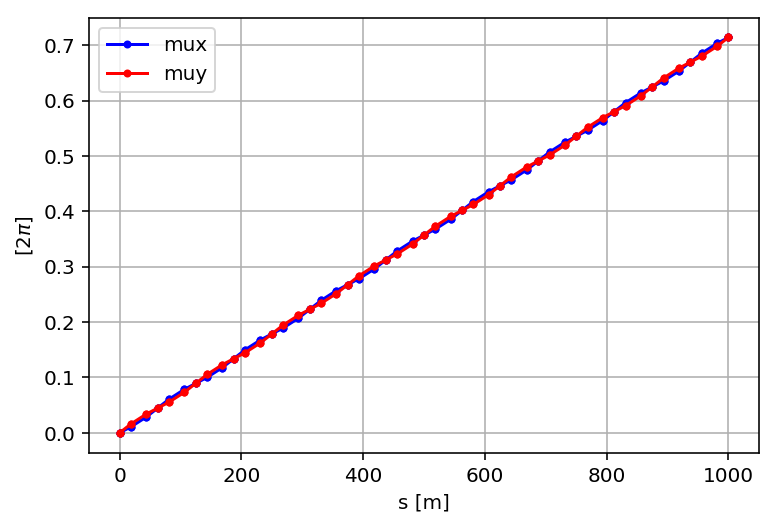

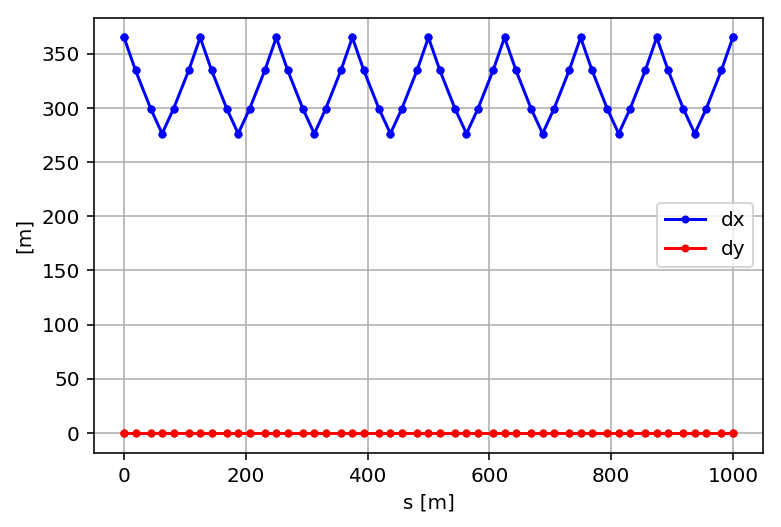

In [11]:
plt.plot(myTwiss.s,myTwiss.betx,'.-b')
plt.plot(myTwiss.s,myTwiss.bety,'.-r')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.alfx,'.-b')
plt.plot(myTwiss.s,myTwiss.alfy,'.-r')
plt.xlabel('s [m]')
plt.ylabel('')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.mux,'.-b')
plt.plot(myTwiss.s,myTwiss.muy,'.-r')
plt.xlabel('s [m]')
plt.ylabel('[2$\pi$]')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.dx,'.-b')
plt.plot(myTwiss.s,myTwiss.dy,'.-r')
plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()